## Training

Using this notebook, we train on a subset of classes (phenotypes). For example, we leave out the mitochondrial phenotype.

**Naming the experiment**

In [1]:
run_desc = 'chong_no_batch_no_mitochondria'#change here for exp id with directories
del_id=8

### Getting the data

Downloading the data if not present

In [2]:
#Taken from https://github.com/okraus/DeepLoc/blob/master/download_datasets.sh
import os
if not (os.path.exists('datasets/Chong_train_set.hdf5')):
    !curl http://spidey.ccbr.utoronto.ca/~okraus/DeepLoc_full_datasets.zip --output DeepLoc_full_datasets.zip
    !unzip DeepLoc_full_datasets.zip
    !rm DeepLoc_full_datasets.zip
!ls -lh datasets

total 3.2G
-rw-r--r-- 1 root root 153M Jan  7  2017 Chong_test_set.hdf5
-rw-r--r-- 1 root root  800 Jul 10 07:49 Chong_test_set.hdf5.hdf5
-rw-r--r-- 1 root root 738M Jan  7  2017 Chong_train_set.hdf5
-rw-r--r-- 1 root root 152M Jan  7  2017 Chong_valid_set.hdf5
-rw-r--r-- 1 root root  740 Jan  8  2017 README.TXT
-rw-r--r-- 1 root root  46M Jan  8  2017 Schuldiner_test_set.hdf5
-rw-r--r-- 1 root root 405M Jan  8  2017 Schuldiner_train_set.hdf5
-rw-r--r-- 1 root root 172M Jan  8  2017 wt2017_test_set.hdf5
-rw-r--r-- 1 root root 1.5G Jan  8  2017 wt2017_train_set.hdf5


In [3]:
!nvidia-smi

Tue Jul 17 12:51:44 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:89:00.0 Off |                    0 |
| N/A   28C    P0    47W / 250W |      0MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import tensorflow as tf
import keras


from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Flatten, Activation
from keras.layers import Lambda, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
from keras import initializers
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.preprocessing.image import ImageDataGenerator

import h5py
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
tf.__version__,keras.__version__, np.__version__, h5py.__version__

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('1.6.0', '2.1.5', '1.14.1', '2.7.1')

## Data Loading

In [5]:
fn1 = 'datasets/Chong_train_set.hdf5'
d1 = h5py.File(fn1)
print(list(d1.keys()))
l = [d for d in zip(np.argmax(d1['Index1'],axis=1), d1['label_names'])]
from collections import Counter
Counter(l)

['Index1', 'Info1', 'data1', 'label_names']


Counter({(0, b'ACTIN'): 738,
         (1, b'BUDNECK'): 535,
         (2, b'BUDTIP'): 336,
         (3, b'CELLPERIPHERY'): 423,
         (4, b'CYTOPLASM'): 1500,
         (5, b'ENDOSOME'): 1500,
         (6, b'ER'): 1500,
         (7, b'GOLGI'): 1500,
         (8, b'MITOCHONDRIA'): 1500,
         (9, b'NUCLEARPERIPHERY'): 1500,
         (10, b'NUCLEI'): 1500,
         (11, b'NUCLEOLUS'): 1500,
         (12, b'PEROXISOME'): 988,
         (13, b'SPINDLE'): 185,
         (14, b'SPINDLEPOLE'): 1500,
         (15, b'VACUOLARMEMBRANE'): 1500,
         (16, b'VACUOLE'): 1500,
         (17, b'DEAD'): 749,
         (18, b'GHOST'): 1428})

In [6]:
def flatBatch2Tensor(batchData,imSize,channels):
    splitByChannel = [batchData[:,(chan*imSize**2):((chan+1)*imSize**2)].reshape((-1,imSize,imSize,1)) \
                      for chan in range(channels)]
    tensorBatchData = np.concatenate(splitByChannel,3)
    return tensorBatchData

def load_kraus():
       
    #fn1 = 'datasets/wt2017_train_set.hdf5'
    #fn2 = 'datasets/wt2017_test_set.hdf5'
    
    fn1 = 'datasets/Chong_train_set.hdf5'
    fn2 = 'datasets/Chong_test_set.hdf5'
    fn3 = 'datasets/Chong_valid_set.hdf5'
    d1 = h5py.File(fn1)
    d2 = h5py.File(fn2)
    d3 = h5py.File(fn3)
    
    X_train = flatBatch2Tensor(d1['data1'][:], 64, 2)
    X_test = flatBatch2Tensor(d2['data1'][:], 64, 2)
    X_valid = flatBatch2Tensor(d3['data1'][:], 64, 2)
    y_train = d1['Index1'][:]
    y_test = d2['Index1'][:]
    y_valid = d3['Index1'][:]
    
    # We bring the data into the range [0,1] and clamp it due to heavy outliers
    X_train = np.clip(X_train,0,100)/100
    X_test = np.clip(X_test,0,100)/100
    X_valid = np.clip(X_valid,0,100)/100
    
    # For sparse labels
    #y_train = np.ndarray.astype(np.argmax(d1['Index1'],axis=1),'int32')
    #y_test = np.ndarray.astype(np.argmax(d2['Index1'],axis=1),'int32')
        
    print("X_train type {} dtype {} shape {}".format(type(X_train), X_train.dtype,np.shape(X_train)))
    print("X_train min {}, max {} mean {}".format(np.min(X_train), np.max(X_train), np.mean(X_train)))
    print("Y_train shape {} Y_test shape{} Y_validation shape{} ".format(np.shape(y_train), np.shape(y_test), np.shape(y_valid)))
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [7]:
import h5py
import numpy as np
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = load_kraus()

X_train type <class 'numpy.ndarray'> dtype float32 shape (21882, 64, 64, 2)
X_train min 0.0, max 1.0 mean 0.17277522385120392
Y_train shape (21882, 19) Y_test shape(4516, 19) Y_validation shape(4491, 19) 


In [8]:
np.max(np.argmax(Y_train, axis=1)) + 1, Y_valid.shape #19 number of classes - 1

(19, (4491, 19))

### Removing cells in the training and validation set

We remove the e.g. mitochondrial cells from the training and validation set.

In [9]:
y_train = np.argmax(Y_train,axis=1)
y_valid = np.argmax(Y_valid,axis=1)
y_test = np.argmax(Y_test,axis=1)

y_max = np.max(y_train) #0,...
num_class_org = y_max + 1
print('Number of classes (original)', num_class_org, '   from', 0, 'to', y_max)

Number of classes (original) 19    from 0 to 18


We build a list of classes which shall be used in the training.

In [10]:
## For myto
if True:
    idx = del_id# here class index to delete
    keep_idx = list(np.linspace(start=0,stop=y_max,num=y_max+1, dtype='int32'))
    keep_idx.remove(idx)


In [11]:
keep_idx

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [12]:
num_classes = len(keep_idx)
print("Number of classes (after cutting)" , num_classes, "to keep from org", keep_idx)

all_to_limited = dict()
limited_to_all = dict()
c = 0
for i in range(num_class_org):
    all_to_limited[i] = c
    limited_to_all[c] = i
    if (keep_idx.count(i) > 0):
        c += 1


Number of classes (after cutting) 18 to keep from org [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [13]:
keep_training = [keep_idx.count(y) > 0 for y in y_train]
X_train_keep = X_train[keep_training]
y_train_keep = [all_to_limited[y] for y in y_train if keep_idx.count(y) > 0] 

keep_valid = [keep_idx.count(y) > 0 for y in y_valid]
X_valid_keep = X_valid[keep_valid]
y_valid_keep = [all_to_limited[y] for y in y_valid if keep_idx.count(y) > 0] 

X_train_keep.shape, X_valid_keep.shape, len(np.unique(y_train_keep)), len(np.unique(y_valid_keep))  

((20382, 64, 64, 2), (3849, 64, 64, 2), 18, 18)

In [14]:
print(len(Y_train) - np.sum(np.argmax(Y_train,axis=1)==del_id))
print(len(Y_valid) - np.sum(np.argmax(Y_valid,axis=1)==del_id))


20382
3849


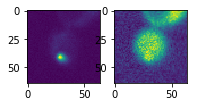

In [15]:
plt.subplot(1,4,1)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,0])
plt.subplot(1,4,2)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,1])

## Building of Model and Training

In [16]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    #zoom_range=[0.1,0.1]
)

In [17]:
# Helper functions
def one_hot(Y, num_cl):
    d = np.zeros((len(Y),num_cl), dtype='int8')
    for row,col in enumerate(Y):
        d[row, col] = 1
    return d
one_hot(np.array((1,0,1,1,2)), 3).shape

(5, 3)

In [18]:
batch_size = 128
train_generator = datagen.flow(
        x = X_train_keep,
        y = one_hot(y_train_keep, num_classes),
        batch_size = batch_size,
        shuffle = True)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20382, 64, 64, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [19]:
tf.reset_default_graph()
model = Sequential()

model.add(Convolution2D(32, (3,3),kernel_initializer='he_normal',padding='same',input_shape=(64,64,2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Convolution2D(32, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())#macht einen vektor aus dem output
model.add(Dropout(0.3))            
model.add(Dense(200,kernel_initializer='he_normal'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
print(model.summary())
model.input_shape, model.output_shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        608       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
__________

((None, 64, 64, 2), (None, 18))

In [21]:
import glob
import os
def create_result_subdir(result_dir, run_desc):
    ordinal = 0
    for fname in glob.glob(os.path.join(result_dir, '*')):
        try:
            fbase = os.path.basename(fname)
            ford = int(fbase[:fbase.find('-')])
            ordinal = max(ordinal, ford + 1)
        except ValueError:
            pass

    result_subdir = os.path.join(result_dir, '%03d-%s' % (ordinal, run_desc))
    if os.path.isdir(result_subdir):
        return create_result_subdir(result_dir, run_desc) # Retry.
    if not os.path.isdir(result_subdir):
        os.makedirs(result_subdir)
    return result_subdir, ordinal

In [22]:
resdir, ordinal = create_result_subdir('results_bayes', run_desc)

In [23]:
resdir

'results_bayes/021-chong_no_batch_no_mitochondria'

In [24]:
tb_cb = keras.callbacks.TensorBoard(log_dir=resdir, histogram_freq=0, write_graph=True)

In [25]:
checkpointer = keras.callbacks.ModelCheckpoint( 
    filepath =  resdir+"/weights_Chong_data_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
    verbose = 1, 
    save_best_only = False,
    period = 25 )

In [26]:
one_hot(y_valid_keep, num_classes).shape, num_classes, num_class_org,one_hot(y_train_keep, num_classes).shape

((3849, 18), 18, 19, (20382, 18))

In [27]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = X_train_keep.shape[0]/batch_size,
                    epochs = 500,                    
                    validation_data = (X_valid_keep, one_hot(y_valid_keep, num_classes)),
                    verbose = 1,
                    callbacks=[checkpointer, tb_cb]
)
model.save(resdir+"/final.keras.model")

Epoch 1/500
160/159 [==============================] - 21s 129ms/step - loss: 2.5049 - acc: 0.1981 - val_loss: 2.0788 - val_acc: 0.3554
Epoch 2/500
160/159 [==============================] - 19s 117ms/step - loss: 1.9500 - acc: 0.3434 - val_loss: 1.9021 - val_acc: 0.3676
Epoch 3/500
160/159 [==============================] - 18s 115ms/step - loss: 1.7117 - acc: 0.4182 - val_loss: 1.5903 - val_acc: 0.5032
Epoch 4/500
160/159 [==============================] - 18s 115ms/step - loss: 1.5555 - acc: 0.4688 - val_loss: 1.4596 - val_acc: 0.5225
Epoch 5/500
160/159 [==============================] - 18s 115ms/step - loss: 1.4175 - acc: 0.5163 - val_loss: 1.3295 - val_acc: 0.5783
Epoch 6/500
160/159 [==============================] - 18s 116ms/step - loss: 1.3424 - acc: 0.5356 - val_loss: 1.2470 - val_acc: 0.5916
Epoch 7/500
160/159 [==============================] - 19s 118ms/step - loss: 1.2781 - acc: 0.5592 - val_loss: 1.1214 - val_acc: 0.6345
Epoch 8/500
160/159 [===========================

160/159 [==============================] - 19s 117ms/step - loss: 0.4391 - acc: 0.8517 - val_loss: 0.3287 - val_acc: 0.8891
Epoch 60/500
160/159 [==============================] - 18s 114ms/step - loss: 0.4287 - acc: 0.8521 - val_loss: 0.3167 - val_acc: 0.8950
Epoch 61/500
160/159 [==============================] - 18s 114ms/step - loss: 0.4265 - acc: 0.8557 - val_loss: 0.3297 - val_acc: 0.8854
Epoch 62/500
160/159 [==============================] - 18s 113ms/step - loss: 0.4194 - acc: 0.8548 - val_loss: 0.3082 - val_acc: 0.9008
Epoch 63/500
160/159 [==============================] - 19s 116ms/step - loss: 0.4202 - acc: 0.8592 - val_loss: 0.3006 - val_acc: 0.8995
Epoch 64/500
160/159 [==============================] - 18s 113ms/step - loss: 0.4115 - acc: 0.8609 - val_loss: 0.3026 - val_acc: 0.9049
Epoch 65/500
160/159 [==============================] - 18s 112ms/step - loss: 0.4210 - acc: 0.8587 - val_loss: 0.3353 - val_acc: 0.8917
Epoch 66/500
160/159 [==============================] 

160/159 [==============================] - 19s 116ms/step - loss: 0.3330 - acc: 0.8866 - val_loss: 0.2713 - val_acc: 0.9104
Epoch 118/500
160/159 [==============================] - 18s 114ms/step - loss: 0.3217 - acc: 0.8885 - val_loss: 0.2787 - val_acc: 0.9078
Epoch 119/500
160/159 [==============================] - 18s 115ms/step - loss: 0.3255 - acc: 0.8893 - val_loss: 0.2931 - val_acc: 0.9078
Epoch 120/500
160/159 [==============================] - 18s 113ms/step - loss: 0.3259 - acc: 0.8877 - val_loss: 0.2782 - val_acc: 0.9098
Epoch 121/500
160/159 [==============================] - 19s 116ms/step - loss: 0.3173 - acc: 0.8906 - val_loss: 0.2536 - val_acc: 0.9148
Epoch 122/500
160/159 [==============================] - 18s 115ms/step - loss: 0.3195 - acc: 0.8916 - val_loss: 0.2644 - val_acc: 0.9122
Epoch 123/500
160/159 [==============================] - 19s 116ms/step - loss: 0.3178 - acc: 0.8915 - val_loss: 0.2792 - val_acc: 0.9065
Epoch 124/500
160/159 [=========================

Epoch 175/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2786 - acc: 0.9050 - val_loss: 0.2970 - val_acc: 0.9054

Epoch 00175: saving model to results_bayes/021-chong_no_batch_no_mitochondria/weights_Chong_data_epoch_175-0.30.hdf5
Epoch 176/500
160/159 [==============================] - 18s 114ms/step - loss: 0.2864 - acc: 0.9012 - val_loss: 0.2677 - val_acc: 0.9195
Epoch 177/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2770 - acc: 0.9070 - val_loss: 0.2877 - val_acc: 0.9101
Epoch 178/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2847 - acc: 0.9018 - val_loss: 0.2841 - val_acc: 0.9171
Epoch 179/500
160/159 [==============================] - 19s 117ms/step - loss: 0.2699 - acc: 0.9075 - val_loss: 0.2513 - val_acc: 0.9252
Epoch 180/500
160/159 [==============================] - 18s 114ms/step - loss: 0.2682 - acc: 0.9071 - val_loss: 0.2593 - val_acc: 0.9241
Epoch 181/500
160/159 [==============================]

Epoch 232/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2675 - acc: 0.9095 - val_loss: 0.2541 - val_acc: 0.9288
Epoch 233/500
160/159 [==============================] - 19s 117ms/step - loss: 0.2566 - acc: 0.9145 - val_loss: 0.2484 - val_acc: 0.9254
Epoch 234/500
160/159 [==============================] - 18s 114ms/step - loss: 0.2662 - acc: 0.9110 - val_loss: 0.2689 - val_acc: 0.9171
Epoch 235/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2613 - acc: 0.9109 - val_loss: 0.2325 - val_acc: 0.9288
Epoch 236/500
160/159 [==============================] - 18s 113ms/step - loss: 0.2569 - acc: 0.9132 - val_loss: 0.2686 - val_acc: 0.9156
Epoch 237/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2497 - acc: 0.9134 - val_loss: 0.2388 - val_acc: 0.9267
Epoch 238/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2562 - acc: 0.9119 - val_loss: 0.2702 - val_acc: 0.9197
Epoch 239/500
160/159 [===========

160/159 [==============================] - 18s 115ms/step - loss: 0.2448 - acc: 0.9171 - val_loss: 0.2476 - val_acc: 0.9234
Epoch 290/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2421 - acc: 0.9160 - val_loss: 0.2180 - val_acc: 0.9304
Epoch 291/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2447 - acc: 0.9144 - val_loss: 0.2357 - val_acc: 0.9267
Epoch 292/500
160/159 [==============================] - 18s 113ms/step - loss: 0.2368 - acc: 0.9186 - val_loss: 0.2624 - val_acc: 0.9200
Epoch 293/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2418 - acc: 0.9144 - val_loss: 0.2403 - val_acc: 0.9286
Epoch 294/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2431 - acc: 0.9177 - val_loss: 0.2452 - val_acc: 0.9241
Epoch 295/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2387 - acc: 0.9172 - val_loss: 0.2809 - val_acc: 0.9195
Epoch 296/500
160/159 [=========================

Epoch 347/500
160/159 [==============================] - 18s 116ms/step - loss: 0.2228 - acc: 0.9242 - val_loss: 0.2296 - val_acc: 0.9286
Epoch 348/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2272 - acc: 0.9205 - val_loss: 0.2339 - val_acc: 0.9288
Epoch 349/500
160/159 [==============================] - 18s 114ms/step - loss: 0.2334 - acc: 0.9197 - val_loss: 0.2206 - val_acc: 0.9309
Epoch 350/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2233 - acc: 0.9231 - val_loss: 0.2391 - val_acc: 0.9304

Epoch 00350: saving model to results_bayes/021-chong_no_batch_no_mitochondria/weights_Chong_data_epoch_350-0.24.hdf5
Epoch 351/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2223 - acc: 0.9239 - val_loss: 0.2615 - val_acc: 0.9210
Epoch 352/500
160/159 [==============================] - 18s 114ms/step - loss: 0.2282 - acc: 0.9213 - val_loss: 0.2311 - val_acc: 0.9283
Epoch 353/500
160/159 [==============================]

Epoch 404/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2159 - acc: 0.9260 - val_loss: 0.2447 - val_acc: 0.9291
Epoch 405/500
160/159 [==============================] - 18s 115ms/step - loss: 0.2125 - acc: 0.9274 - val_loss: 0.3108 - val_acc: 0.9083
Epoch 406/500
160/159 [==============================] - 19s 117ms/step - loss: 0.2197 - acc: 0.9254 - val_loss: 0.2213 - val_acc: 0.9299
Epoch 407/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2190 - acc: 0.9246 - val_loss: 0.2396 - val_acc: 0.9252
Epoch 408/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2126 - acc: 0.9287 - val_loss: 0.2394 - val_acc: 0.9265
Epoch 409/500
160/159 [==============================] - 19s 118ms/step - loss: 0.2237 - acc: 0.9236 - val_loss: 0.2503 - val_acc: 0.9244
Epoch 410/500
160/159 [==============================] - 18s 114ms/step - loss: 0.2156 - acc: 0.9261 - val_loss: 0.2447 - val_acc: 0.9288
Epoch 411/500
160/159 [===========

160/159 [==============================] - 18s 114ms/step - loss: 0.2012 - acc: 0.9318 - val_loss: 0.2562 - val_acc: 0.9275
Epoch 462/500
160/159 [==============================] - 18s 113ms/step - loss: 0.2127 - acc: 0.9284 - val_loss: 0.2312 - val_acc: 0.9314
Epoch 463/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2033 - acc: 0.9307 - val_loss: 0.2029 - val_acc: 0.9358
Epoch 464/500
160/159 [==============================] - 19s 116ms/step - loss: 0.2067 - acc: 0.9290 - val_loss: 0.2275 - val_acc: 0.9337
Epoch 465/500
160/159 [==============================] - 19s 117ms/step - loss: 0.2124 - acc: 0.9275 - val_loss: 0.2585 - val_acc: 0.9260
Epoch 466/500
160/159 [==============================] - 19s 118ms/step - loss: 0.2220 - acc: 0.9247 - val_loss: 0.2269 - val_acc: 0.9343
Epoch 467/500
160/159 [==============================] - 19s 118ms/step - loss: 0.2163 - acc: 0.9267 - val_loss: 0.2776 - val_acc: 0.9179
Epoch 468/500
160/159 [=========================

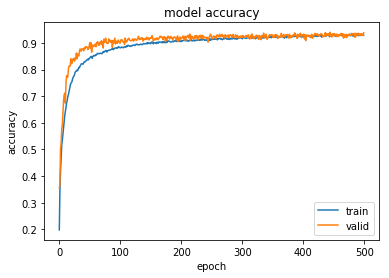

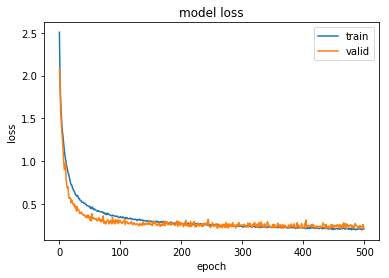

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()